In [1]:
%load_ext autoreload
%autoreload 2

import syft as sy
from syft.serde import protobuf
from syft_proto.execution.v1.plan_pb2 import Plan as PlanPB
from syft_proto.execution.v1.state_pb2 import State as StatePB
from syft.grid.clients.model_centric_fl_client import ModelCentricFLClient
from syft.execution.state import State
from syft.execution.placeholder import PlaceHolder
from syft.frameworks.torch.tensors.interpreters.autograd import AutogradTensor
from syft.execution.translation import TranslationTarget

import torch as th
from torch import nn

import os
import numpy as np
from websocket import create_connection
import websockets
import json
import requests
from functools import reduce

sy.make_hook(globals())
hook.local_worker.framework = None # force protobuf serialization for tensors
th.random.manual_seed(1)

Setting up Sandbox...
Done!


In [2]:
th.set_printoptions(precision=8)

### Helpers for debugging purposes

In [3]:
def printTensorSum(tensor, tensorName):
  print(tensorName, 'sum:', tensor.sum())

def printTensorArraySum(tensorArray, tensorArrayName):
    sumTensorArray = [tensor.sum() for tensor in tensorArray]
    print(tensorArrayName, 'sum:', sum(sumTensorArray))


In [4]:
def save_model(modelParams, filePath):
  params = [param.detach().numpy() for param in modelParams]
  np.save(filePath , params, allow_pickle=True)

def load_model(model, filePath):
  np_params = np.load(filePath, allow_pickle=True)
  model_params = [param.data.copy_(th.from_numpy(np_params[i])) for i, param in enumerate(model.parameters())]
  
modelPath = 'modelFemnistSavedParams.npy'
modelPath187 = 'weights_for_round_187.npy'
modelPath188 = 'weights_for_round_188.npy'
modelPath1 = 'weights_for_round_1.npy'
modelPathForPruning = 'pytorch_weights_1549775860.npy'

In [5]:
def load_tf_model(filePath):
    th_np_params = np.load(filePath, allow_pickle=True)
    tf_np_params = []
    for i, param in enumerate(th_np_params):
        if i % 2 != 0:
            tf_np_params.append(param)
        elif i == 0 or i == 2:
            tf_np_params.append(param.transpose(2, 3, 1, 0))
        else:
            tf_np_params.append(param.transpose())

    return tf_np_params 

In [6]:
def save_custom_tensor(tensor, filePath):
    np_tensor = tensor.detach().numpy()
    np.save(filePath, np_tensor.child.child, allow_pickle=True)
    
def load_custom_tensor(filePath):
    torchTensor = th.tensor(np.load(filePath, allow_pickle=True), requires_grad=True)
    placeHolderTensor = PlaceHolder().on(torchTensor, wrap=False)
    return AutogradTensor().on(placeHolderTensor, wrap=False)

def load_tensor(filePath):
    return th.tensor(np.load(filePath, allow_pickle=True), requires_grad=True)


### Defining Syft models

In [7]:
def set_model_params(module, params_list, start_param_idx=0):
    """ Set params list into model recursively
    """
    param_idx = start_param_idx

    for name, param in module._parameters.items():
        module._parameters[name] = params_list[param_idx]
        param_idx += 1

    for name, child in module._modules.items():
        if child is not None:
            param_idx = set_model_params(child, params_list, param_idx)

    return param_idx

In [8]:
def own_softmax(x): ##computes softmax of a given value of x
#     xExp = x.exp()
    return x.exp()/x.exp().sum(dim = 1, keepdim = True)

In [9]:
INPUT_DIM = 10
CLASSES = 5
# th.set_default_dtype(th.float64)
class FemnistNet(nn.Module):
    def __init__(self):
        super(FemnistNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2) ##output shape (batch, 32, 28, 28)
#         th.nn.init.xavier_uniform_(self.conv1.weight)
#         th.nn.init.kaiming_uniform(self.conv1.weight)

        self.pool1 = nn.MaxPool2d(2, stride=2, ) ## output shape (batch, 32, 14, 14)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2) ##output shape (batch, 64, 14, 14)
#         th.nn.init.xavier_uniform_(self.conv2.weight)
#         th.nn.init.kaiming_uniform(self.conv2.weight)


        self.pool2 = nn.MaxPool2d(2, stride=2) ## output shape (batch, 64, 7, 7)
        
        self.fc1 = nn.Linear(3136, 2048)
#         th.nn.init.xavier_uniform_(self.fc1.weight)
#         th.nn.init.kaiming_uniform(self.fc1.weight)

        
        self.fc2 = nn.Linear(2048 ,62)
#         th.nn.init.xavier_uniform_(self.fc2.weight)
#         th.nn.init.kaiming_uniform(self.fc2.weight)

        
        
    def forward(self, x):
#         printTensorSum(x, 'INPUT')
#         print('INPUT SHAPE:', x.shape)
        x = x.view(-1, 1, 28, 28)
        x = self.conv1(x)
        x = th.nn.functional.relu(x)
        
#         printTensorSum(x, 'CONV1')
#         save_custom_tensor(x, 'conv1_pysyft.npy')


        x = self.pool1(x)

        x=self.conv2(x)
        x = th.nn.functional.relu(x)
        
#         printTensorSum(x, 'CONV2')
#         save_custom_tensor(x, 'conv2_pysyft.npy')
        
        
        x = self.pool2(x)
        
        x = x.flatten(start_dim=1)
        
        x = self.fc1(x)
        l1_activations = th.nn.functional.relu(x)
#         save_custom_tensor(l1_activations, 'linear1_pysyft.npy')
        
        
#         printTensorSum(l1_activations, 'FC1')
        
        x = self.fc2(l1_activations)
        
#         printTensorSum(x, 'FC2')

# #         x = x.softmax()
#         save_custom_tensor(x, 'linear2_pysyft.npy')


        return x, l1_activations
    

# th.set_default_dtype(th.float64)
class FemnistNetSmall(nn.Module):
    def __init__(self):
        super(FemnistNetSmall, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2) ##output shape (batch, 32, 28, 28)
#         th.nn.init.xavier_uniform_(self.conv1.weight)

        
        self.pool1 = nn.MaxPool2d(2, stride=2) ## output shape (batch, 32, 14, 14)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2) ##output shape (batch, 64, 14, 14)
#         th.nn.init.xavier_uniform_(self.conv2.weight)
        
        
        self.pool2 = nn.MaxPool2d(2, stride=2) ## output shape (batch, 64, 7, 7)
        
        self.fc1 = nn.Linear(1568, 1024) ##input of [BatchSize, 3136]. output of [BatchSize, 2048]
#         th.nn.init.xavier_uniform_(self.fc1.weight)

        self.fc2 = nn.Linear(1024 ,62) ##input of [BatchSize, 2048]. output of [BatchSize, 62]
#         th.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28) ##reshape 1D array to 3D image to be passed to conv2d layer
        
        x = self.conv1(x) ##apply first convolution operation 
        x = th.nn.functional.relu(x) ##apply relu

        x = self.pool1(x) ##first pooling layer
        
        x=self.conv2(x)
        x = th.nn.functional.relu(x)

        x = self.pool2(x)
        x = x.flatten(start_dim=1)
        
        
        x = self.fc1(x) ##apply first linear layer operation
        l1_activations = th.nn.functional.relu(x)
        
        
        x = self.fc2(l1_activations)
#         x = x.softmax() ##apply softmax on output of second dense layer

        return x, l1_activations

In [10]:
def cross_entropy_with_logits(log_logits, targets, batch_size):
    eps = PlaceHolder().on(th.tensor(1e-7), wrap = False)
    return -(targets * th.log(log_logits + eps)).sum() / batch_size
#     return -(targets * log_logits).sum() / batch_size

def softmax_cross_entropy_with_logits(logits, targets, batch_size):
    """ Calculates softmax entropy
        Args:
            * logits: (NxC) outputs of dense layer
            * targets: (NxC) one-hot encoded labels
            * batch_size: value of N, temporarily required because Plan cannot trace .shape
    """
    # numstable logsoftmax
    norm_logits = logits - logits.max(dim = 1, keepdim = True)[0]
    log_probs = norm_logits - norm_logits.exp().sum(dim=1, keepdim=True).log()
    
    # NLL, reduction = mean
    return -(targets * log_probs).sum() / batch_size

## Data Loading

In [12]:
# trainFile1500 = 'data_custom/single_format/train/client_train_1500.json'
# testFile250 = 'data_custom/single_format/test/client_test_250.json'

# trainFile500 = 'data_custom/single_format/train/slow_client_train_500.json'
# testFile150 = 'data_custom/single_format/test/slow_client_test_150.json'

trainFile = 'sample.json'
testFile = 'sample_test.json'

# trainFile1 = 'data_custom/single_format/train/debug_testbed.json'
# testFile1 = 'data_custom/single_format/test/debug_testbed_test.json'

# trainFile2 = 'data_custom/single_format/train/debug_testbed2.json'
# testFile2 = 'data_custom/single_format/test/debug_testbed2_test.json'

femnistUser = {}
with open(trainFile, 'r') as f:
    femnistUser = json.load(f)

emnistUser = {}
with open(testFile, 'r') as f:
    femnistUserTest = json.load(f)


dataX = np.array(femnistUser['x'])
dataY = np.array(femnistUser['y'])

dataX_test = np.array(femnistUserTest['x'])
dataY_test = np.array(femnistUserTest['y'])

X = th.tensor(dataX, dtype=th.float)
y = nn.functional.one_hot(th.tensor(dataY), 62)


X_test = th.tensor(dataX_test, dtype=th.float)
y_test = nn.functional.one_hot(th.tensor(dataY_test), 62)

### Defining syft training plan

In [13]:
def naive_sgd(param, **kwargs):
    return param - kwargs['lr'] * param.grad

In [14]:
batch_size = th.tensor([20])
lr = th.tensor([0.0003])

model = FemnistNet()
# np_params = np.load('params.npy', allow_pickle=True)

# model_params = [param.data.copy_(th.from_numpy(np_params[i])) for i, param in enumerate(model.parameters())]

# load_model(model, modelPath)
model_params = [param.data for param in model.parameters()]

In [15]:
def get_average_over_examples(activations, total_examples):
    reduced_sum = th.sum(activations, dim=0)#reduce(th.add, activations)
    return th.div(reduced_sum, total_examples)

@sy.func2plan()
def training_plan(X, y, batch_size, lr, model_params):
    model = FemnistNet() 
    model.float()
    model.train()
    
    # inject params into model
    
#     printTensorArraySum(model_params, 'MODEL_PARAMS')
    set_model_params(model, model_params)
    
    
    logits, activations = model.forward(X)
    loss = softmax_cross_entropy_with_logits(logits, y, batch_size)

    
    #     loss = cross_entropy_with_logits(logits, y, batch_size)
    
    save_custom_tensor(loss, 'loss_pysyft.npy')
    
        
    # backprop
    loss.backward()
    
    print('Batch size after backpass:', batch_size)
    
    param_gradients = [param.grad for param in model.parameters()]
    
#     print("Logits:", logits)
    
#     for i, param_gradient in enumerate(param_gradients):
#         print("Shape:", param_gradient.shape, "Sum:", param_gradient.sum().child.data)
    

    updated_params = [
        naive_sgd(param, lr=lr)
        for param in model_params
    ]

    # accuracy
    pred = th.argmax(logits, dim=1)
    target = th.argmax(y, dim=1)
    acc = pred.eq(target).sum()/ batch_size
    
    print("Acc:", acc)
    
    avg_act_over_examples = get_average_over_examples(activations, list(X.shape)[0])
    
    
    return (
        loss,
        acc,
        logits,
        avg_act_over_examples,
        *updated_params,        
    )


@sy.func2plan()
def training_plan_small(X, y, batch_size, lr, model_params):
    model = FemnistNetSmall() 
    model.train()
    
    # inject params into model
    set_model_params(model, model_params)
    
    
    logits, activations = model.forward(X)
    
#     loss = cross_entropy_with_logits(logits, y, batch_size)
    loss = softmax_cross_entropy_with_logits(logits, y, batch_size)
        
        
    # backprop
    loss.backward()
    

    updated_params = [
        naive_sgd(param, lr=lr)
        for param in model_params
    ]
    
    # accuracy
    pred = th.argmax(logits, dim=1)
    target = th.argmax(y, dim=1)
    acc = pred.eq(target).sum()/ batch_size
    
    print("Acc:", acc)
    
    avg_act_over_examples = get_average_over_examples(activations, list(X.shape)[0])
    
    return (
        loss,
        acc,
        logits,
        avg_act_over_examples,
        *updated_params,        
    )

In [17]:
model = FemnistNet() ##model


# print(model_params)
# [print(model_param.shape) for model_param in model_params]

num = 10
X = th.tensor((dataX), dtype=th.float) ##784 sized 1D array. would be reshaped to 1, 28, 28
y = nn.functional.one_hot(th.tensor(dataY), 62) ##62-length sized one hot vectors

lr = th.tensor([0.0003]) ##0.0003 learning rate
batch_size = th.tensor([float(num)]) ##20 is our batch size

loss, acc, logits, target, *updated_params, _ = training_plan.build(X[0:num], y[0:num], batch_size, lr, model_params, trace_autograd=True)
# updated_params
loss

Batch size after backpass: AutogradTensor>PlaceHolder[Id:96468674254]>tensor([10.])
Acc: AutogradTensor>PlaceHolder[Id:21008175216]>tensor([0.])


AutogradTensor>PlaceHolder[Id:79807912222]>tensor([18.61926651])

In [18]:
model_small = FemnistNetSmall() ##model
    
model_params_small = [param.data for param in model_small.parameters()]  # raw tensors instead of nn.Parameter


X = th.tensor(np.zeros((10, 784)), dtype=th.float) ##784 sized 1D array. would be reshaped to 1, 28, 28
y = nn.functional.one_hot(th.tensor(np.zeros(20, dtype=np.int64)), 62) ##62-length sized one hot vectors

lr = th.tensor([0.0003]) ##0.0003 learning rate
batch_size = th.tensor([float(10)]) ##20 is our batch size

loss, acc, logits, target, *updated_params, _ = training_plan_small.build(X[0:10], y[0:10], batch_size, lr, model_params_small, trace_autograd=True)

Acc: AutogradTensor>PlaceHolder[Id:41590466556]>tensor([0.])


In [19]:
loss

AutogradTensor>PlaceHolder[Id:23780437349]>tensor([4.16340876])

In [20]:
from torch.autograd import Variable

@sy.func2plan()
def evaluate_model_plan(X, y, batch_size, model_params):
    model = FemnistNet()
    model.eval()
    # Load model params into the model
    set_model_params(model, model_params)
    
    # Test
    logits, activations = model(X)
    preds = th.argmax(logits, dim=1)
    target = th.argmax(y, dim=1)
    
    acc = preds.eq(target).sum().float() / batch_size
    loss = softmax_cross_entropy_with_logits(logits, y, batch_size)
    
    #mean_acc = th.mean(preds.eq(target).float())
    print(acc, loss)
    
    return acc, loss

# test_x = th.randn(3, INPUT_DIM)
# test_y = nn.functional.one_hot(th.tensor([2,3,4]), CLASSES)

# test_x = th.tensor(np.ones(shape=(5, 1, 28, 28)), dtype=th.float)
# test_y = th.tensor(np.zeros(shape=(5, 62)))

model = FemnistNet()
# model.load_state_dict(th.load('./torch_model_weights'))
# np_params = np.load('params.npy', allow_pickle=True)

# model_params = [param.data.copy_(th.from_numpy(np_params[i])) for i, param in enumerate(model.parameters())]

# load_model(model, modelPath)
model_params = [param.data for param in model.parameters()]

test_x = th.tensor(dataX_test, dtype=th.float)
test_y = nn.functional.one_hot(th.tensor(dataY_test), 62) ##62-length sized one hot vectors


# model_params = prune_model(model_params, create_mask(model_params))

num = len(dataX_test)
#evaluate_model_plan(test_x, test_y, th.tensor([3.0]), model_params)
evaluate_model_plan.build(test_x[:num], test_y[:num], th.tensor(float(num)), model_params, trace_autograd=True)

AutogradTensor>PlaceHolder[Id:64711083574]>0.007499999832361937 AutogradTensor>PlaceHolder[Id:92881170128]>22.396770477294922


(AutogradTensor>PlaceHolder[Id:64711083574]>0.007499999832361937,
 AutogradTensor>PlaceHolder[Id:92881170128]>22.396770477294922)

In [28]:
model = FemnistNet()
# np_params = np.load('params.npy', allow_pickle=True)

# model_params = [param.data.copy_(th.from_numpy(np_params[i])) for i, param in enumerate(model.parameters())]

# load_model(model, modelPath)
modelParams = [param.data for param in model.parameters()]


In [29]:
dataX.shape

(2000, 784)

## Client Class

In [54]:
def getAllData(path):
    with open(path, 'r') as f:
        user_data = json.load(f)
        
    return th.tensor(user_data['x'], dtype=th.float), nn.functional.one_hot(th.tensor(user_data['y']), 62)
    
class Client:
    def __init__(self, train_data_path, test_data_path, training_plan_large, training_plan_small, eval_plan, is_slow = False):
        self.dataX_train, self.dataY_train = getAllData(train_data_path)
        self.dataX_test, self.dataY_test = getAllData(test_data_path)
        
        self.training_plan = training_plan_small if is_slow else training_plan_large
        self.eval_plan = eval_plan
        
        self.is_slow = is_slow
        
    
    def getNumSamples(self):
        return self.getTrainSamples() + self.getTestSamples()
    
    def getTestSamples(self):
        return len(self.dataY_test)
    
    def getTrainSamples(self):
        return len(self.dataY_train)
    
        
    def getBatch(self, batch_size):
        batch_size_int = int(batch_size[0])
        for i in range(0, len(self.dataY_train), batch_size_int):
            end_index = i + batch_size_int if i + batch_size_int < len(self.dataY_train) else len(self.dataY_train)
            yield (self.dataX_train[i:end_index], self.dataY_train[i:end_index])
            
    def getTestAccAndLoss(self, model_params):
        return self.eval_plan(self.dataX_test, self.dataY_test, th.tensor([len(self.dataY_test)]), model_params)
            
    
    def run_epochs(self, epochs, modelParams, batch_size, lr):
        activations = []
        if self.is_slow == False:
            for epoch in range(epochs):
                print("Epoch: ", epoch)
                for batch in self.getBatch(batch_size):
                    _, _, _, l2_activation, *updated_params = self.training_plan(batch[0], batch[1], batch_size, lr, modelParams.copy())
                    modelParams = updated_params
                    activations.append(l2_activation)
        if len(activations) == 0:
            return modelParams, None
        else:
            return modelParams, sum(activations)/len(activations)

## Pruning functions

In [55]:
layer_indexes = [0, 2, 4]
bias_indexes = list(map(lambda i : i + 1, layer_indexes))

def convert_filters_to_neuron_indices(filters, resulting_kernel_size):
    neuron_indices = []
    total_indices_in_one_filter = resulting_kernel_size * resulting_kernel_size
    for filter_index in filters:
        starting_index = filter_index * total_indices_in_one_filter
        for i in range(total_indices_in_one_filter):
            neuron_indices.append(i + starting_index)
    return neuron_indices

## Removing neurons & filters
def remove_neurons_layer(weights, indices_to_remove):
    return np.delete(weights, indices_to_remove, axis=0)

def remove_neurons_next_layer(weights_next_layer, indices_to_remove):
    return np.delete(weights_next_layer, indices_to_remove, axis=1)

def remove_filters_layer(filters, indices_to_remove):
    return np.delete(filters, indices_to_remove, axis=0)

def remove_filters_next_layer(next_layer, indices_to_remove):
    return np.delete(next_layer, indices_to_remove, axis=1)

def remove_neurons_bias(bias, indices_to_remove):
    return np.delete(bias, indices_to_remove)

## Inserting neurons & filters
def insert_neurons_layer(weights, indices):
    new_weights = weights.copy() 
    for i in indices:
        new_weights = np.insert(new_weights, i, 0, axis=0)
    return new_weights

def insert_neurons_next_layer(weights_next_layer, indices):
    new_weights = weights_next_layer.copy() 
    for i in indices:
        new_weights = np.insert(new_weights, i, 0, axis=1)
    return new_weights

def insert_filters_layer(filters, indices):
    new_filters = filters.copy()
    for i in indices:
        new_filters = np.insert(new_filters, i, 0, axis=0)
    return new_filters

def insert_filters_next_layer(filters, indices):
    new_filters = filters.copy()
    for i in indices:
        new_filters = np.insert(new_filters, i, 0, axis=1)
    return new_filters

def insert_neurons_bias(bias, indices_to_add):
    prev_con = bias
    indices = indices_to_add
    for i in indices:
        prev_con = np.insert(prev_con, i, 0, axis=0)
    return prev_con


def printModelDimensions(model):
    for layer in model:
        print(layer.shape)

def convert_str_to_mask(str_mask):
    return np.array([int(i) for i in str_mask.split(',')])


def prune_model(modelParams, str_masks):
    model_params = modelParams.copy()
    str_masks = str_masks.split(';')

    masks = list(map(lambda str_mask : convert_str_to_mask(str_mask), str_masks))


    for i, layer_index in enumerate(layer_indexes):
        mask = masks[i]
        indices_to_remove = np.where(np.array(mask) == 0)[0]

        if layer_index == 0:
            model_params[0] = remove_filters_layer(model_params[0], indices_to_remove)
            model_params[2] = remove_filters_next_layer(model_params[2], indices_to_remove)
            
        elif layer_index == 2:
            numFilters = modelParams[2].shape[0]
            numNeuronsShape = modelParams[4].shape[0]
            
            model_params[2] = remove_filters_layer(model_params[2], indices_to_remove)
#             model_params[4] = model_params[4].t().reshape(7, 7, numFilters, -1).permute(3, 2, 0, 1)
            neuron_indices_to_prune = convert_filters_to_neuron_indices(indices_to_remove, 7)
            model_params[4] = remove_neurons_next_layer(model_params[4], neuron_indices_to_prune)
#             model_params[4] = model_params[4].permute(2, 3, 1, 0).reshape(-1, numNeuronsShape).t()
        
        elif layer_index == 4:
            model_params[4] = remove_neurons_layer(model_params[4], indices_to_remove)
            
            model_params[6] = remove_neurons_next_layer(model_params[6], indices_to_remove)
            
       
        model_params[bias_indexes[i]] = remove_neurons_bias(model_params[bias_indexes[i]],
                                                                 indices_to_remove)
    
    return model_params


def convert_pruned_model_to_original(modelParams, str_masks):
    model_params = modelParams.copy()
    second_last_hidden_layer_params = model_params[-4]
    second_last_hidden_layer_bias = model_params[-3]
    output_layer = model_params[-2]


    str_masks = str_masks.split(';')
    masks = list(map(lambda str_mask : convert_str_to_mask(str_mask), str_masks))
    
    for i, layer_index in enumerate(layer_indexes):
        mask = masks[i]
        indices_to_remove = np.where(np.array(mask) == 0)[0]

        if layer_index == 0:
            model_params[0] = insert_filters_layer(model_params[0], indices_to_remove)
            model_params[2] = insert_filters_next_layer(model_params[2], indices_to_remove)
            
        elif layer_index == 2:
            numFilters = model_params[2].shape[0]
            numNeuronsDense = model_params[4].shape[0]
            
            model_params[2] = insert_filters_layer(model_params[2], indices_to_remove)
#             model_params[4] = model_params[4].t().reshape(7, 7, numFilters, -1).permute(3, 2, 0, 1)
#             model_params[4] = insert_filters_next_layer(model_params[4], indices_to_remove).permute(2, 3, 1, 0).reshape(-1, numNeuronsDense).t()
            neuron_indices_to_add = convert_filters_to_neuron_indices(indices_to_remove, 7)
            model_params[4] = insert_neurons_next_layer(model_params[4], neuron_indices_to_add)
        
        elif layer_index == 4:
            model_params[4] = insert_neurons_layer(model_params[4], indices_to_remove)
            model_params[6] = insert_neurons_next_layer(model_params[6], indices_to_remove)
        
       
        model_params[bias_indexes[i]] = insert_neurons_bias(model_params[bias_indexes[i]],
                                                                 indices_to_remove)


    return model_params


def convert_pruned_activations_to_original(masks, activation_):
    activation = activation_.copy()
    mask = convert_str_to_mask(masks.split(';')[2])

    indices_to_add = np.where( mask == 0)[0]

    original_scaled_activation = insert_neurons_bias(activation, indices_to_add)

    array = []
    array.append(original_scaled_activation)

    return original_scaled_activation


def create_mask(params):
    str_mask = ""

    drop_rate = 0.5

    for layer_index in layer_indexes:
        if layer_index == 0 or layer_index == 2:
            filter_shape = list(params[layer_index].shape)
            number_of_filters = filter_shape[0]
            mask = np.zeros(number_of_filters)
            filters_to_keep = math.ceil(number_of_filters - (drop_rate * number_of_filters))
            random_indices = np.random.choice(number_of_filters, size=filters_to_keep, replace=False)
            values = [1] * len(random_indices)

            np.put(mask, random_indices, values)

            str_mask += ','.join([str(int(num)) for num in mask])
            str_mask += ";"
            
        else:
            transposed_weights = th.transpose(params[layer_index], 0, 1)
            neurons_shape = list(transposed_weights.shape)
            number_of_neurons = neurons_shape[1]
            mask = np.zeros(number_of_neurons)
            neurons_to_keep = math.ceil(number_of_neurons - (drop_rate * number_of_neurons))
            random_indices = np.random.choice(number_of_neurons, size=neurons_to_keep, replace=False)
            values = [1] * len(random_indices)

            np.put(mask, random_indices, values)

            str_mask += ','.join([str(int(num)) for num in mask])
            

    return str_mask

def update_mask(activations, prune_percentage):
        """
            Based on bootstrap rounds update the mask for pruning the model
        """        
        addition = th.stack(activations, dim=0).sum(dim=0)
        avg_activations = th.div(addition, len(activations))


        m = np.ones(len(avg_activations), dtype=int)
        N = int(len(avg_activations) * prune_percentage)
        argSortArray = avg_activations.argsort()

        rind = argSortArray[:N].numpy()

        m[rind] = 0

        return ','.join([str(int(num)) for num in m])


In [56]:
fileName = 'pysyft_simulation.csv'
with open(fileName, 'w') as f:
    f.write('Epoch,NumSamples,Type,Accuracy,Loss\n')

## Setting up clients & model

In [57]:
def logClientEval(epoch, client, acc, loss, file):
    with open(file, 'a') as f:
        strToWrite = str(epoch) + ',' + str(client.getNumSamples()) + ',' + ('L' if client.is_slow else 'H') + ',' + str(float(acc)) + ',' + str(float(loss)) + '\n'
        f.write(strToWrite)
        
def getAvgAccuracyAndLoss(epoch, modelParams, prunedModelParams, clients, file):
    totalNumSamples = 0
    avg_acc = 0
    avg_loss = 0
    for client in clients:
        modelParamsToServe = prunedModelParams if client.is_slow else modelParams
        totalNumSamples += client.getNumSamples()
        acc, loss = client.getTestAccAndLoss(modelParamsToServe)
        print('Acc model with samples', client.getNumSamples(), acc)
        avg_acc += (acc * client.getNumSamples())
        avg_loss += (loss * client.getNumSamples())
        

        logClientEval(epoch, client, acc, loss, file)
        
    avg_acc /= totalNumSamples
    avg_loss /= totalNumSamples
    
    with open(file, 'a') as f:
        strToWrite = str(epoch) + ',' + str(totalNumSamples) + ',' + 'A' + ',' + str(float(avg_acc)) + ',' + str(float(avg_loss)) + '\n'
        f.write(strToWrite)
    
    return avg_acc, avg_loss

In [58]:
def where(filterArr, arr1, arr2, axis = 0):
    if arr1.shape != arr2.shape:
        print('Error: arr1 and arr2 must have equal shapes')
        return
    res = th.zeros(arr1.shape, dtype=arr1.dtype)
    for i in range(filterArr.shape[0]):
        if axis == 0:
            res[i] = arr1[i] if filterArr[i] else arr2[i]
        elif axis == 1:
            res[:,i] = arr1[:,i] if filterArr[i] else arr2[:,i]
    return res

def aggregate_conv_dense_layer(weights_all, weights_high, layer_no, mask):
    weights_all[layer_no] = where(mask, weights_all[layer_no], weights_high[layer_no])
    weights_all[layer_no + 1] = where(mask, weights_all[layer_no + 1], weights_high[layer_no + 1])
    weights_all[layer_no + 2] = where(mask, weights_all[layer_no + 2], weights_high[layer_no + 2], axis=1)
    return weights_all

def get_averaged_params(updates, weights, totalWeight):
    aggregatedParams = [th.zeros(param.shape) for param in updates[0]]
    for i, params in enumerate(updates):
        for layer_index, param in enumerate(params):
            aggregatedParams[layer_index] += ((param * weights[i])/totalWeight)
            
    return aggregatedParams
    
    
def weighted_std(average, values, weights, totalWeight):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    std = [th.zeros(param.shape) for param in average]
    for i, value in enumerate(values):
        totalWeight += weights[i]
        
        for layer_no, layer in enumerate(value):
            variance_layer = (layer - average[layer_no])**2
            variance_layer = (variance_layer * weights[i])/totalWeight
            std[layer_no] += th.sqrt(variance_layer)
    
    return std

def get_aggregated_weights(masks, average_params, average_params_high):
    for i, mask in enumerate(masks):
        if i == 0 or i == 2:
            averaged_soln = aggregate_conv_dense_layer(average_params, average_params_high, i * 2, mask)
        elif i == 1:
            numFilters = average_params[2].shape[0]
            numNeuronsDense = average_params[4].shape[0]            

            average_params[4] = average_params[4].reshape(-1, numFilters, 7, 7)
            average_params_high[4] = average_params_high[4].reshape(-1, numFilters, 7, 7)
            
            averaged_soln = aggregate_conv_dense_layer(average_params, average_params_high, i * 2, mask)
            
            average_params[4] = average_params[4].reshape(numNeuronsDense, -1)
            average_params_high[4] = average_params_high[4].reshape(numNeuronsDense, -1)
            
    return averaged_soln


def get_aggregated_weights_clt(masks, average_params, average_params_high, std_params, std_params_high):
    for i, mask in enumerate(masks):
        if i == 0 or i == 2:
            averaged_soln = aggregate_conv_dense_layer(average_params, average_params_high, i * 2, mask)
            std_soln = aggregate_conv_dense_layer(std_params, std_params_high, i * 2, mask)
        elif i == 1:
            numFilters = average_params[2].shape[0]
            numNeuronsDense = average_params[4].shape[0]            

            average_params[4] = average_params[4].reshape(-1, numFilters, 7, 7)
            average_params_high[4] = average_params_high[4].reshape(-1, numFilters, 7, 7)
            
            std_params[4] = std_params[4].reshape(-1, numFilters, 7, 7)
            std_params_high[4] = std_params_high[4].reshape(-1, numFilters, 7, 7)
            
            averaged_soln = aggregate_conv_dense_layer(average_params, average_params_high, i * 2, mask)
            std_soln = aggregate_conv_dense_layer(std_params, std_params_high, i * 2, mask)
            
            
            average_params[4] = average_params[4].reshape(numNeuronsDense, -1)
            average_params_high[4] = average_params_high[4].reshape(numNeuronsDense, -1)
            
            std_params[4] = std_params[4].reshape(numNeuronsDense, -1)
            std_params_high[4] = std_params_high[4].reshape(numNeuronsDense, -1)
            
    return averaged_soln, std_soln

In [59]:
# X_test = th.tensor(dataX_test, dtype=th.float)
# y_test = nn.functional.one_hot(th.tensor(dataY_test), 62)
# X = th.tensor(dataX, dtype=th.float)
# y = nn.functional.one_hot(th.tensor(dataY), 62)

trainFileFast = 'train_fast_random_20_2.json'
testFileFast = 'test_fast_random_20_2.json'

trainFileSlow = 'train_slow_random_20_1.json'
testFileSlow = 'test_slow_random_20_1.json'

trainfastClient = {}
testfastClient = {}
with open(trainFileFast, 'r') as f:
    trainfastClient = json.load(f)
with open(testFileFast, 'r') as f:
    testfastClient = json.load(f)

trainslowClient = {}
testslowClient = {}
with open(trainFileSlow, 'r') as f:
    trainslowClient = json.load(f)
with open(testFileSlow, 'r') as f:
    testslowClient = json.load(f)
    
fast_client = Client(trainFileFast,
                 testFileFast,
                 training_plan.torchscript, 
                 training_plan_small.torchscript, 
                 evaluate_model_plan.torchscript)

slow_client = Client(trainFileSlow,
                 testFileSlow,
                 training_plan.torchscript, 
                 training_plan_small.torchscript, 
                 evaluate_model_plan.torchscript,
                True)

clients = [fast_client, slow_client]

In [60]:
import math
epochs = 10
rounds = 100
batch_size = th.tensor([float(10)])
lr = th.tensor([0.0003])
needToPrune = False

if needToPrune:
    model = FemnistNet()
else:
    model = FemnistNet()
     
# load_model(model, modelPathForPruning)
# load_model(model, 'kamming_femnist_model.npy')
modelParams = [param.data for param in model.parameters()]
bootstrap_rounds = 10

In [61]:
# str_masks = create_mask(modelParams.copy())
str_masks='0,1,1,0,1,1,0,1,0,0,0,1,0,0,0,1,1,0,1,1,0,0,1,1,0,0,0,0,1,1,1,1;1,0,0,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,0,0,0,1,0,1,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,0,1,1,0,1,1,0,0,0,0;0,0,1,0,0,1,1,1,0,0,1,1,0,1,1,1,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,1,1,0,1,1,1,0,1,1,1,0,1,0,0,1,0,0,1,1,0,1,1,1,0,1,0,1,0,0,0,1,1,1,1,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,1,1,1,1,1,1,0,1,0,0,0,1,1,1,1,1,0,1,0,1,1,1,1,1,1,0,1,0,1,0,0,0,1,1,1,0,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,0,0,0,1,1,1,0,0,0,1,1,0,1,1,1,0,0,1,0,1,0,0,0,0,0,1,1,0,1,1,1,0,0,0,0,0,1,1,1,0,1,1,0,1,1,1,0,0,0,1,1,1,0,0,1,1,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,1,0,1,1,0,1,1,1,0,0,1,1,1,1,1,0,1,1,0,0,1,1,1,1,1,1,1,1,0,1,0,0,1,0,0,0,0,0,1,1,1,0,1,1,1,0,0,0,1,0,1,1,0,1,0,1,1,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,1,0,1,1,1,1,0,0,1,0,1,1,1,0,1,1,1,1,1,1,1,0,1,1,0,0,1,1,1,1,0,0,0,0,1,1,0,0,1,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,0,1,1,1,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,0,1,0,1,0,1,1,1,0,1,0,1,1,1,0,1,0,0,1,0,1,1,1,0,1,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,1,1,0,1,0,1,0,0,0,1,1,1,1,1,0,1,1,1,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,1,1,1,1,0,0,0,1,0,1,1,0,1,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,1,0,1,0,1,0,1,0,0,0,1,0,1,1,1,0,1,1,0,1,1,0,1,0,0,1,1,0,0,1,1,1,0,0,0,1,0,0,1,1,1,0,1,0,1,0,1,1,1,0,1,0,1,0,1,1,0,1,0,0,1,1,1,0,0,0,1,1,1,0,0,1,0,0,0,0,0,1,0,1,1,1,1,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,1,1,0,0,1,0,1,0,1,1,1,0,0,1,1,1,0,0,0,1,0,0,0,1,1,1,1,1,1,1,0,0,0,0,1,0,1,1,1,1,1,1,0,1,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,1,1,0,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,1,0,1,1,0,1,1,1,1,0,1,0,1,0,1,1,1,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1,1,1,1,1,1,1,1,0,0,0,0,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,1,0,0,0,1,0,1,0,0,0,1,1,0,1,1,0,1,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,1,0,1,1,1,0,1,0,0,1,0,1,1,0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,1,0,0,1,0,0,1,0,1,1,0,1,0,0,1,0,1,1,1,1,1,0,0,1,0,1,0,0,1,1,1,0,0,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,1,1,1,0,1,1,1,0,1,0,0,0,1,1,0,0,1,0,0,1,0,1,0,0,1,1,1,1,0,1,1,0,0,0,1,0,0,1,0,1,0,1,1,1,1,1,1,0,1,0,1,1,1,0,0,0,1,1,1,0,1,1,1,0,0,1,0,0,1,0,0,1,1,1,1,1,0,0,1,1,1,0,1,1,0,0,0,0,1,1,1,0,1,0,1,1,0,1,1,1,0,0,0,1,1,1,0,1,0,0,0,0,1,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,1,0,1,1,0,0,0,1,1,0,0,1,1,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,1,1,1,0,0,0,1,0,1,1,0,0,0,0,1,1,0,1,0,0,1,1,0,0,1,1,0,1,0,1,1,1,1,0,1,0,0,0,1,0,0,1,1,0,1,1,1,1,0,1,1,0,0,0,1,0,1,0,1,0,0,0,0,1,1,1,1,0,0,1,0,1,1,1,1,0,1,0,0,1,1,1,0,0,1,1,0,1,1,1,1,0,0,0,1,1,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,1,1,1,1,0,0,1,1,0,0,0,1,0,1,1,1,0,0,0,1,1,0,1,1,1,1,1,0,1,1,1,0,1,0,1,0,1,1,0,0,1,1,0,0,1,1,0,0,0,1,1,0,1,1,1,1,0,0,1,1,0,1,0,1,1,1,0,0,1,0,1,1,0,0,0,1,1,1,0,1,1,1,0,0,0,1,0,1,0,0,0,1,1,1,0,0,1,0,1,1,0,0,0,1,0,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,1,1,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,1,1,1,1,0,1,1,0,1,0,0,1,1,1,1,1,1,0,0,0,0,1,1,0,1,1,1,0,0,0,0,0,1,0,1,0,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,1,1,0,0,1,1,1,1,0,0,0,1,1,1,1,0,0,1,1,0,0,1,1,0,0,0,0,1,0,1,0,1,1,0,1,1,0,0,1,0,1,0,1,0,1,1,1,0,0,1,1,1,1,0,1,0,0,0,0,0,0,1,0,1,1,1,1,1,0,0,1,0,1,1,0,1,0,0,0,1,0,0,1,1,0,1,1,1,1,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,0,1,0,1,1,1,0,1,1,0,1,0,1,0,0,1,1,1,0,1,0,1,1,0,1,1,0,0,0,0,1,1,1,0,1,1,0,0,1,0,1,1,0,1,1,0,1,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,1,1,0,1,0,1,1,0,1,0,0,1,1,0,1,0,1,0,0,0,1,1,0,1,1,1,0,1,0,1,1,0,0,1,0,0,0,1,1,0,0,1,1,1,1,0,1,0,0,1,1,0,0,0,1,0,0,0,1,1,1,1,1,1,0,1,0,0,0,1,1,1,1,0,1,0,1,0,0,1,1,1,0,0,0,0,0,0,1,1,0,0,1,1,1,0,0,1,1,1,0,1,0,1,0,0,1,0,1,0,0,0,1,0,1,0,1,1,1,0,1,1,1,0,1,1,1,0,1,0,1,0,0,0,1,1,1,0,1,0,0,0,1,1,0,1,0,1,1,0,0,1,1,1,1,1,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,1,0,0,0,0,1,0,1,1,0,1,0,0,0,1,0,0,0,0,0,1,0,1,1,1,0,1,0,1,1,1,0,0,0,1,0,0,0,1,0,1,1,1,0,1,1,0,1,1,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,1,0,1,0,0,0,0,0,1,0,1,1,1,0,0,1,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,1,0,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,1,0,0,1,1,1,1,0,0,0,1,0,1,1,1,1,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1,1,0,1,0,1,1,0,1,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,1,1,1,1,0,0,1,0,0,0,0,1,1,1,0,0,1,0,0,1,0,1,0,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,1,0,0,0,1,0,0,1,0'

In [62]:
training_plan_torchscript = training_plan.torchscript
training_plan_small_torchscript = training_plan_small.torchscript

evaluate_model_plan_torchscript = evaluate_model_plan.torchscript

## Training

#### Note: Currently, mask is not being updated and averaging isn't selective (same averaging for all clients)

In [ ]:
activations = []
torch_losses = []
torch_accs = []
masks = list(map(lambda str_mask : convert_str_to_mask(str_mask), str_masks.split(';')))

for e in range(rounds):
    print("Round No: ", e)
    evaluate_model_plan_copy = evaluate_model_plan.copy()
    
#     if e % bootstrap_rounds == 0 and e != 0:
#         print('updating mask')
#         old_masks = str_masks.split(";")
#         old_masks[2] = update_mask(activations, 0.5)
#         str_masks = ';'.join(old_masks)
#         activations = []



    prunedModelParams = prune_model(modelParams.copy(), str_masks)
    
    allNumSamples = []
    allHighNumSamples = []
    
    allModelParams = []
    highModelParams = []
    
    totalNumSamples = 0
    totalHighNumSamples = 0
    
    testSamples = 0
    
    weighted_epoch_acc, weighted_epoch_loss = getAvgAccuracyAndLoss(e, modelParams, prunedModelParams, clients, fileName)
    print('Epoch', e, 'Acc:', weighted_epoch_acc, 'Loss:', weighted_epoch_loss)
    print()    
    
    for client in clients:
        modelParamsToServe = prunedModelParams if client.is_slow and needToPrune else modelParams
        allNumSamples.append(client.getNumSamples())
        totalNumSamples += client.getNumSamples()
        
        if not client.is_slow:
            allHighNumSamples.append(client.getNumSamples())
            totalHighNumSamples += client.getNumSamples()
        
                
        updatedModelParams, l2_activation = client.run_epochs(epochs, modelParamsToServe.copy(), batch_size, lr)
                    
        if client.is_slow and needToPrune:
            updatedModelParams = convert_pruned_model_to_original(updatedModelParams, str_masks)
            mask = masks[2]
            indices_to_add = np.where( mask == 0)
            l2_activation = convert_pruned_activations_to_original(str_masks, l2_activation)
        
    
#         updatedModelParams = [param for param in updatedModelParams]
        allModelParams.append(updatedModelParams)
        
        if not client.is_slow:
            highModelParams.append(updatedModelParams)
            
    
    averaged_params = get_averaged_params(allModelParams, allNumSamples, totalNumSamples)
#     averaged_params_high = get_averaged_params(allModelParams, allNumSamples, totalNumSamples)
    
#     std_params = weighted_std(averaged_params, allModelParams, allNumSamples, totalNumSamples)
#     std_params_high = weighted_std(averaged_params_high, highModelParams, allHighNumSamples, totalHighNumSamples)
    
#     aggregatedParams, aggregatedStd = get_aggregated_weights_clt(masks, averaged_params, averaged_params_high, std_params, std_params_high)        
#     new_params = [th.normal(mean = aggregatedParams[i], std = aggregatedStd[i]) for i in range(len(aggregatedParams))]
        
#     modelParams = new_params
    modelParams = averaged_params

    torch_losses.append(weighted_epoch_loss)
    torch_accs.append(weighted_epoch_acc)


Round No:  0
Acc model with samples 250 tensor([0.06000000])
Acc model with samples 250 tensor([0.14000000])
Epoch 0 Acc: tensor([0.10000000]) Loss: tensor([11.26898575], grad_fn=<DivBackward0>)

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Round No:  1
Acc model with samples 250 tensor([0.04000000])
Acc model with samples 250 tensor([0.12000000])
Epoch 1 Acc: tensor([0.08000000]) Loss: tensor([6.16666508], grad_fn=<DivBackward0>)

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Round No:  2
Acc model with samples 250 tensor([0.50000000])
Acc model with samples 250 tensor([0.10000000])
Epoch 2 Acc: tensor([0.30000001]) Loss: tensor([3.99033332], grad_fn=<DivBackward0>)

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Round No:  3
Acc model with samples 250 tensor([0.56000000])
Acc model with samples 250 tensor([0.02000000])
Epoch

Epoch:  7
Epoch:  8
Epoch:  9
Round No:  28
Acc model with samples 250 tensor([0.60000002])
Acc model with samples 250 tensor([0.02000000])
Epoch 28 Acc: tensor([0.31000000]) Loss: tensor([3.80127740], grad_fn=<DivBackward0>)

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Round No:  29
Acc model with samples 250 tensor([0.60000002])
Acc model with samples 250 tensor([0.02000000])
Epoch 29 Acc: tensor([0.31000000]) Loss: tensor([3.80477691], grad_fn=<DivBackward0>)

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Round No:  30
Acc model with samples 250 tensor([0.60000002])
Acc model with samples 250 tensor([0.02000000])
Epoch 30 Acc: tensor([0.31000000]) Loss: tensor([3.80814838], grad_fn=<DivBackward0>)

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Round No:  31
Acc model with samples 250 tensor([0.60000002])
Acc model with sa

## Plotting graphs

In [307]:
import matplotlib.pyplot as plt
import pandas as pd

In [323]:
len(activations)def getCsvRow(vals):
    row = list(map(lambda val : str(val), vals))
    row = ','.join(row)
    row += '\n'
    return row

import os

feddrop_50_percent_2_clients = pd.read_csv('50_percent_2_clients_feddrop.csv')
feddrop_50_percent_2_clients_clt = pd.read_csv('50_percent_2_clients_feddrop_clt.csv')

In [324]:
feddrop_slow_client = feddrop_50_percent_2_clients[feddrop_50_percent_2_clients['num_samples'] == 650]
feddrop_slow_client = feddrop_slow_client[feddrop_slow_client['set'] == 'test']

feddrop_fast_client = feddrop_50_percent_2_clients[feddrop_50_percent_2_clients['num_samples'] == 1750]
feddrop_fast_client = feddrop_fast_client[feddrop_fast_client['set'] == 'test']

avg_acc = (np.array(feddrop_slow_client['accuracy'] * 650) + np.array(feddrop_fast_client ['accuracy'] * 1750))/2400
avg_loss = (np.array(feddrop_slow_client['loss'] * 650) + np.array(feddrop_fast_client ['loss'] * 1750))/2400

In [352]:
feddrop_clt_slow_client = feddrop_50_percent_2_clients_clt[feddrop_50_percent_2_clients_clt['num_samples'] == 650]
feddrop_clt_slow_client = feddrop_clt_slow_client[feddrop_clt_slow_client['set'] == 'test']

feddrop_clt_fast_client = feddrop_50_percent_2_clients_clt[feddrop_50_percent_2_clients_clt['num_samples'] == 1750]
feddrop_clt_fast_client = feddrop_clt_fast_client[feddrop_clt_fast_client['set'] == 'test']

avg_acc_clt = (np.array(feddrop_clt_slow_client['accuracy'] * 650) + np.array(feddrop_clt_fast_client ['accuracy'] * 1750))/2400
avg_loss_clt = (np.array(feddrop_clt_slow_client['loss'] * 650) + np.array(feddrop_clt_fast_client ['loss'] * 1750))/2400

In [353]:
testbed_500_fast = pd.read_csv('testbed_500_fast.csv')
pytorch_500_fast = pd.read_csv('pytorch_500_fast.csv')
tf_500_fast = pd.read_csv('tf_500_fast.csv')

In [354]:
pysyft_50_percent_2_clients = pd.read_csv(fileName)

pysyft_slow_client = pysyft_50_percent_2_clients[pysyft_50_percent_2_clients['Type'] == 'L']
pysyft_fast_client = pysyft_50_percent_2_clients[pysyft_50_percent_2_clients['Type'] == 'H']
pysyft_avg = pysyft_50_percent_2_clients[pysyft_50_percent_2_clients['Type'] == 'A']


pysyft_avg_acc = np.array(pysyft_avg['Accuracy'])
pysyft_avg_loss = np.array(pysyft_avg['Loss'])

In [355]:
# plt.pl
# plt.title('Average Accuracy: PySyft vs Tensorflow - 50 percent pruning - 1 fast, 1 slow')
# plt.ylabel('Accuracy')
# plt.xlabel('Round/Epoch')
# plt.show()

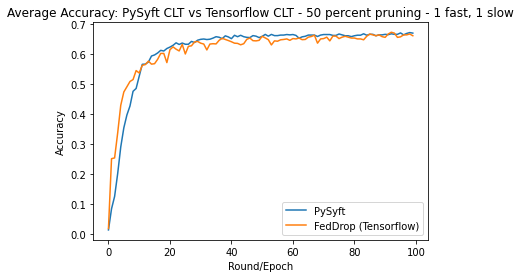

In [359]:
# plt.plot(kammingFemnist['Accuracy'])

# plt.plot(list(testbed_500_fast['accuracy'])[0:len(torch_losses)])
# plt.plot(list(pytorch_500_fast['acc'])[0:len(torch_losses)])

# plt.plot(list(tf_500_fast['acc'])[0:len(torch_losses)])
plt.plot(pysyft_avg_acc)
plt.plot(avg_acc_clt[:len(torch_accs)])

# plt.plot(hist2.history['accuracy'])
# plt.plot(history.history['loss'])
# plt.plot(list(femnist_stat_train['loss'])[0:len(torch_losses)])

plt.title('Average Accuracy: PySyft CLT vs Tensorflow CLT - 50 percent pruning - 1 fast, 1 slow')
plt.ylabel('Accuracy')
plt.xlabel('Round/Epoch')

plt.legend(['PySyft', 'FedDrop (Tensorflow)'], loc='lower right')

plt.savefig('pysyft_vs_tf_clt_acc_2_clients')
plt.show()

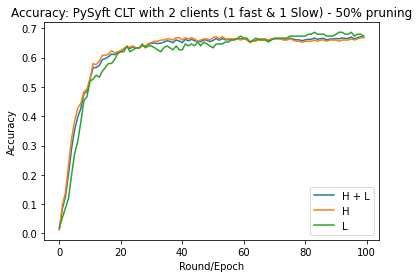

In [360]:
# plt.plot(kammingFemnist['Accuracy'])

# plt.plot(list(testbed_500_fast['accuracy'])[0:len(torch_losses)])
# plt.plot(list(pytorch_500_fast['acc'])[0:len(torch_losses)])

# plt.plot(list(tf_500_fast['acc'])[0:len(torch_losses)])
plt.plot(pysyft_avg_acc)
plt.plot(list(pysyft_fast_client['Accuracy']))
plt.plot(list(pysyft_slow_client['Accuracy']))


# plt.plot(hist2.history['accuracy'])
# plt.plot(history.history['loss'])
# plt.plot(list(femnist_stat_train['loss'])[0:len(torch_losses)])

plt.title('Accuracy: PySyft CLT with 2 clients (1 fast & 1 Slow) - 50% pruning')
plt.ylabel('Accuracy')
plt.xlabel('Round/Epoch')

plt.legend(['H + L', 'H', 'L'], loc='lower right')

plt.savefig('pysyft_clt_2_clients_50_percent')
plt.show()

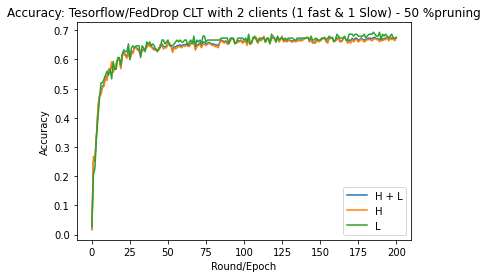

In [361]:
# plt.plot(kammingFemnist['Accuracy'])

# plt.plot(list(testbed_500_fast['accuracy'])[0:len(torch_losses)])
# plt.plot(list(pytorch_500_fast['acc'])[0:len(torch_losses)])

# plt.plot(list(tf_500_fast['acc'])[0:len(torch_losses)])
plt.plot(avg_acc_clt)
plt.plot(list(feddrop_clt_fast_client['accuracy']))
plt.plot(list(feddrop_clt_slow_client['accuracy']))


# plt.plot(hist2.history['accuracy'])
# plt.plot(history.history['loss'])
# plt.plot(list(femnist_stat_train['loss'])[0:len(torch_losses)])

plt.title('Accuracy: Tesorflow/FedDrop CLT with 2 clients (1 fast & 1 Slow) - 50 %pruning')
plt.ylabel('Accuracy')
plt.xlabel('Round/Epoch')

plt.legend(['H + L', 'H', 'L'], loc='lower right')

plt.savefig('feddrop_clt_2_clients_50_percent')
plt.show()

In [65]:
# plt.plot(kammingFemnist['Accuracy'])

plt.plot(list(testbed_500_fast['loss'])[0:len(torch_losses)])
plt.plot(list(pytorch_500_fast['loss'])[0:len(torch_losses)])

plt.plot(list(list(map(lambda x : float(x), torch_losses))))
# plt.plot(hist2.history['accuracy'])
# plt.plot(history.history['loss'])
# plt.plot(list(femnist_stat_train['loss'])[0:len(torch_losses)])

plt.title('Loss: PySyft vs PyTorch vs Testbed')
plt.ylabel('Loss')
plt.xlabel('Round/Epoch')

plt.legend(['Testbed', 'PyTorch', 'PySyft'], loc='lower right')

plt.savefig('pysyft_testbed_pytorch_loss')
plt.show()

NameError: name 'plt' is not defined

In [131]:
modelParams = [param.detach() for param in FemnistNet().parameters()]

In [132]:
prunedModel = prune_model(modelParams, str_masks)

In [133]:
for i, param in enumerate(modelParams):
    print(param.shape)

torch.Size([32, 1, 5, 5])
torch.Size([32])
torch.Size([64, 32, 5, 5])
torch.Size([64])
torch.Size([2048, 3136])
torch.Size([2048])
torch.Size([62, 2048])
torch.Size([62])


In [134]:
originalModel = convert_pruned_model_to_original(prunedModel.copy(), str_masks)

In [135]:
originalModel

[tensor([[[[ 0.00000000,  0.00000000,  0.00000000,  0.00000000,  0.00000000],
           [ 0.00000000,  0.00000000,  0.00000000,  0.00000000,  0.00000000],
           [ 0.00000000,  0.00000000,  0.00000000,  0.00000000,  0.00000000],
           [ 0.00000000,  0.00000000,  0.00000000,  0.00000000,  0.00000000],
           [ 0.00000000,  0.00000000,  0.00000000,  0.00000000,  0.00000000]]],
 
 
         [[[ 0.04844368,  0.05829063,  0.06482986, -0.00037938,  0.03582773],
           [-0.04473288,  0.03160680, -0.07192211,  0.04808041, -0.01475582],
           [-0.04021096, -0.01238550,  0.07502086,  0.02516533,  0.04875748],
           [-0.08481959,  0.03014215,  0.06911427, -0.02099419,  0.00149267],
           [-0.05584396, -0.05114162, -0.08379941, -0.07522546,  0.00803423]]],
 
 
         [[[-0.01890411,  0.02716055,  0.08087714,  0.06115712,  0.08462429],
           [ 0.03856171,  0.06971835,  0.08150141,  0.02088659, -0.04605213],
           [ 0.06806611,  0.05744293,  0.08113788, -

In [136]:
prunedModel2 = prune_model(originalModel.copy(), str_masks)

In [137]:
prunedModel

[tensor([[[[ 0.04844368,  0.05829063,  0.06482986, -0.00037938,  0.03582773],
           [-0.04473288,  0.03160680, -0.07192211,  0.04808041, -0.01475582],
           [-0.04021096, -0.01238550,  0.07502086,  0.02516533,  0.04875748],
           [-0.08481959,  0.03014215,  0.06911427, -0.02099419,  0.00149267],
           [-0.05584396, -0.05114162, -0.08379941, -0.07522546,  0.00803423]]],
 
 
         [[[-0.01890411,  0.02716055,  0.08087714,  0.06115712,  0.08462429],
           [ 0.03856171,  0.06971835,  0.08150141,  0.02088659, -0.04605213],
           [ 0.06806611,  0.05744293,  0.08113788, -0.04898061, -0.02105553],
           [ 0.01540595,  0.04489534,  0.03256555,  0.03316144, -0.06504034],
           [ 0.02001496,  0.07980520, -0.06566805, -0.01010335, -0.04405257]]],
 
 
         [[[ 0.07423592, -0.05125437, -0.06619664, -0.01274159,  0.01021489],
           [-0.06276517,  0.08011705,  0.03748520, -0.06229507,  0.06602916],
           [ 0.00473219, -0.05548393, -0.02807406, -

In [138]:
[prunedModel2[i].sum() - prunedModel[i].sum() for i in range(len(prunedModel))]

[tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.)]

In [139]:
x = np.array([[1, 2, 3],
             [4, 5, 6]])

indices = [0, 2, 4]

for i in indices:
    x = np.insert(x, i, 0, axis=0)

In [140]:
x

array([[0, 0, 0],
       [1, 2, 3],
       [0, 0, 0],
       [4, 5, 6],
       [0, 0, 0]])

In [141]:
np.delete(x, indices, axis=0)

array([[1, 2, 3],
       [4, 5, 6]])

In [33]:
def convertTorchParamsToTF(th_np_params_):
    th_np_params = th_np_params_.copy()
    tf_np_params = []
    for i, param in enumerate(th_np_params):
        if i % 2 != 0:
            tf_np_params.append(param)
        elif i == 0 or i == 2:
            tf_np_params.append(param.transpose(2, 3, 1, 0))
        else:
            tf_np_params.append(param.transpose())

    return tf_np_params 
                    

In [7]:
model_params = [param.detach().numpy() for param in FemnistNet().parameters()]
model_params_tf = convertTorchParamsToTF(model_params)

In [8]:
# torchParams = [param.detach().numpy() for param in model_params]
indices_to_remove_ = [i for i in range(0, 64, 2)]

In [9]:
neuron_indices_to_prune = convert_filters_to_neuron_indices(indices_to_remove_, 7)
comp1 = remove_neurons_next_layer(model_params[4], neuron_indices_to_prune)

NameError: name 'convert_filters_to_neuron_indices' is not defined

In [125]:
comp2 = remove_filters_next_layer(model_params[4].reshape(-1, 64, 7, 7), indices_to_remove_).reshape(2048, -1)

In [126]:
modelParams[4].shape, (comp1 == comp2).sum() == (comp1.shape[0] * comp1.shape[1])

(torch.Size([2048, 3136]), True)

In [127]:
comp1_tf = np.delete(model_params_tf[4].copy(), neuron_indices_to_prune, axis = 0)
comp2_tf = np.delete(model_params_tf[4].reshape(7, 7, 64, -1), indices_to_remove_, axis = 2).reshape(-1, 2048)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [131]:
comp2_tf

array([[-0.01131314, -0.02805465, -0.00452592, ...,  0.03110808,
        -0.0081866 ,  0.01150165],
       [ 0.02661739,  0.00250652,  0.00383391, ..., -0.03372315,
         0.03283475,  0.0042488 ],
       [ 0.02692273,  0.02182747, -0.02595685, ...,  0.00902402,
         0.03318946,  0.01438079],
       ...,
       [-0.03041965,  0.01002558,  0.03144941, ...,  0.01759308,
         0.02555424,  0.01308179],
       [-0.00215481,  0.01847753,  0.0111186 , ..., -0.03004795,
         0.01075993, -0.03022461],
       [-0.01584445, -0.01495346,  0.01423285, ...,  0.01149589,
         0.02739929, -0.0087856 ]], dtype=float32)

In [175]:
reshaped_layer_4_tf[:,:,0,0] == reshaped_layer_4_th[0,0,:,:]

array([[ True, False, False, False, False, False, False],
       [False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False]])

In [173]:
reshaped_layer_4_tf[:,:,0,0]

array([[-3.3667248e-02,  1.1791922e-02, -1.5521424e-02, -2.9741099e-02,
        -3.2523800e-02,  1.4626086e-02,  1.2047417e-02],
       [-2.4339147e-03, -3.1263407e-02, -1.3361754e-02,  4.4008680e-03,
        -1.9189849e-02, -7.3245205e-03, -2.6377063e-02],
       [ 2.2111367e-02, -3.1224404e-02, -1.6263053e-02,  7.7389181e-05,
        -1.9530669e-02,  1.2474399e-02,  7.2748102e-03],
       [ 4.1123554e-03, -8.4859487e-03,  3.3640474e-02,  3.3443376e-02,
        -1.4399737e-03,  2.7262919e-02, -2.6372895e-03],
       [ 6.2220804e-03,  5.4944009e-03,  2.1667164e-02, -2.7836967e-02,
        -3.3434503e-02,  2.6999999e-02, -1.1504609e-02],
       [ 2.5001474e-02,  2.1872666e-02,  1.1878926e-02, -2.1264255e-02,
        -9.3361419e-03, -1.6122777e-02,  1.5861399e-02],
       [ 2.4418727e-02,  2.8766371e-02,  2.0588916e-02, -1.5329404e-02,
         1.9880321e-02,  2.9752910e-02, -2.3275729e-02]], dtype=float32)

In [174]:
reshaped_layer_4_th[0,0,:,:]

array([[-0.03366725,  0.00843545,  0.01274306, -0.01319763, -0.01539183,
        -0.03327732,  0.02398875],
       [ 0.00142732,  0.02283858,  0.01123451, -0.00888788,  0.02657335,
        -0.00162866, -0.00573828],
       [-0.02683809,  0.02705957,  0.01692493,  0.00764678, -0.01690764,
        -0.02633323, -0.03011203],
       [ 0.02323712, -0.01751038, -0.01486759,  0.0044138 , -0.0014921 ,
        -0.03331087, -0.02846824],
       [-0.02815644,  0.00241011, -0.0010077 ,  0.02428937, -0.0067814 ,
        -0.02011822, -0.00022816],
       [-0.02490951, -0.01180885,  0.00921149,  0.02398837,  0.01401584,
         0.0121631 , -0.00961414],
       [-0.01658495,  0.01327209, -0.00641046,  0.02560753,  0.02371763,
         0.0305793 , -0.03181244]], dtype=float32)

In [ ]:
torch.transpose().permute(3,2).

In [ ]:
count = 0
for i in range(len(weights_layer_4)):
    for j in range(len(weights_layer_4)):
        comparison = weights_layer_4[i] == leaf_weights_layer_4[j].numpy()
        if (comparison.all()):
            print(i, "-->", j)
            count += 1


print(count)


In [178]:
[[a, b]
 [c, d]]




In [54]:
x = np.random.rand(10, 50) #10, 5
y = x.transpose() #5, 10

In [66]:
x_reshaped = x.reshape(10, 2, 5, 5)
y_reshaped = y.reshape(5, 5, 2, 10).transpose(1, 0, 2, 3)

np.set_printoptions(precision=10)

print(x_reshaped[0,0,:,:] == y_reshaped[:,:,0,0])

print('x_reshaped')
print(x_reshaped[0,0,:,:])

print('y_reshaped first filter:')
print(y_reshaped[:,:,0,0])

[[ True False False False False]
 [False False False False False]
 [False False False False False]
 [False  True False False False]
 [False False False False False]]
x_reshaped
[[0.8381639198 0.4161102807 0.1994478473 0.7831800801 0.8313528369]
 [0.6246692627 0.1743852513 0.7492047847 0.4822756918 0.2626059972]
 [0.9425990288 0.363140734  0.8320840698 0.8834993906 0.6796215273]
 [0.4433552718 0.5345840542 0.5567759046 0.8552684374 0.469350499 ]
 [0.884944586  0.9791536883 0.3130908692 0.1584972722 0.9696954475]]
y_reshaped first filter:
[[0.8381639198 0.9425990288 0.884944586  0.6710914297 0.5996697948]
 [0.1994478473 0.8320840698 0.3130908692 0.7058134381 0.6522678065]
 [0.8313528369 0.6796215273 0.9696954475 0.8257342263 0.6421942309]
 [0.1743852513 0.5345840542 0.2449954859 0.7732865204 0.5530661602]
 [0.4822756918 0.8552684374 0.6167653769 0.1594214429 0.7069830247]]


In [37]:
x

array([[0.3668262076, 0.4825731703, 0.4885014324, 0.2731217713,
        0.8529312591, 0.0122788547, 0.9711647569, 0.5497323823,
        0.7476286153, 0.6447445487],
       [0.4690085275, 0.9362824227, 0.4266285632, 0.7267193019,
        0.7003179305, 0.1817239042, 0.4780344558, 0.1682903773,
        0.8459031626, 0.40326962  ],
       [0.980170773 , 0.3766404503, 0.9306496499, 0.7449403453,
        0.3722865803, 0.7230892627, 0.3421237652, 0.8352796869,
        0.8374246459, 0.2712513183],
       [0.2623451506, 0.6541574898, 0.9522122811, 0.7769780296,
        0.8473281613, 0.5156848037, 0.4478182475, 0.9144557135,
        0.9540844006, 0.8499903664],
       [0.5703400117, 0.6828153847, 0.1157582805, 0.2369616003,
        0.146474764 , 0.7064216708, 0.5591952862, 0.5185316104,
        0.9500004283, 0.0829667578],
       [0.6089536945, 0.6375651296, 0.1234536609, 0.3803547185,
        0.4363032671, 0.098980711 , 0.9650800389, 0.8217236826,
        0.5305508439, 0.441931051 ],
       [0.

In [38]:
y

array([[0.3668262076, 0.4690085275, 0.980170773 , 0.2623451506,
        0.5703400117, 0.6089536945, 0.723476543 , 0.9145863113,
        0.1987380143, 0.5435334497],
       [0.4825731703, 0.9362824227, 0.3766404503, 0.6541574898,
        0.6828153847, 0.6375651296, 0.4795700683, 0.6985345219,
        0.8735787425, 0.6239227284],
       [0.4885014324, 0.4266285632, 0.9306496499, 0.9522122811,
        0.1157582805, 0.1234536609, 0.8033154895, 0.292657085 ,
        0.1346375602, 0.0980682691],
       [0.2731217713, 0.7267193019, 0.7449403453, 0.7769780296,
        0.2369616003, 0.3803547185, 0.109109587 , 0.7049788804,
        0.2617170717, 0.007688415 ],
       [0.8529312591, 0.7003179305, 0.3722865803, 0.8473281613,
        0.146474764 , 0.4363032671, 0.7569124426, 0.4030903468,
        0.6751712578, 0.1343349539],
       [0.0122788547, 0.1817239042, 0.7230892627, 0.5156848037,
        0.7064216708, 0.098980711 , 0.6211700046, 0.6346565451,
        0.8427922512, 0.7131073955],
       [0.

array([[ True, False],
       [False, False]])

In [190]:
x_reshaped

array([[[[4.8742943125e-01, 3.4029038861e-01, 7.9780543861e-01,
          3.6600781624e-01, 9.2931479526e-01],
         [2.2531079332e-01, 2.7968934481e-01, 4.7936365409e-01,
          8.0498228614e-01, 2.1918377528e-01],
         [6.7403038945e-01, 7.3936941750e-01, 7.4931434901e-01,
          8.7626828478e-01, 3.2585093742e-01],
         [8.1022346800e-01, 5.7718645685e-01, 8.4281626962e-01,
          5.5476069821e-01, 4.3112244225e-01],
         [9.6575219429e-04, 1.7826002035e-03, 6.0169479264e-01,
          1.9269183004e-01, 8.9772395583e-01]],

        [[2.5007604245e-01, 7.9675493100e-01, 7.6172691749e-01,
          7.4801940999e-01, 7.9799074357e-01],
         [3.6911353868e-01, 7.1530257322e-01, 3.1842481049e-01,
          3.0918370555e-01, 4.8375925017e-01],
         [2.1272098622e-01, 6.2916032630e-01, 1.2147648053e-02,
          5.2247437488e-01, 6.3418485414e-01],
         [3.3590675465e-01, 5.9011714230e-01, 4.9847812919e-01,
          3.2097833140e-01, 4.3013098707e-02],

In [187]:
y_reshaped

array([[[[4.8742943125e-01, 6.7403038945e-01],
         [9.6575219429e-04, 3.6911353868e-01]],

        [[3.3590675465e-01, 1.2680853367e-01],
         [8.1493398954e-01, 3.1910915275e-01]],

        [[7.4484782850e-01, 2.6514108882e-01],
         [3.4029038861e-01, 7.3936941750e-01]],

        [[1.7826002035e-03, 7.1530257322e-01],
         [5.9011714230e-01, 7.8115495131e-01]],

        [[6.4796724026e-01, 8.1296422282e-01],
         [3.1604889436e-01, 8.2888827915e-01]]],


       [[[7.9780543861e-01, 7.4931434901e-01],
         [6.0169479264e-01, 3.1842481049e-01]],

        [[4.9847812919e-01, 7.7033800979e-01],
         [6.0538071125e-01, 3.7386182156e-01]],

        [[9.5911175185e-01, 7.6545479060e-01],
         [3.6600781624e-01, 8.7626828478e-01]],

        [[1.9269183004e-01, 3.0918370555e-01],
         [3.2097833140e-01, 9.9150200816e-01]],

        [[4.6039551867e-01, 2.5717506603e-01],
         [7.2481201123e-01, 2.6546947824e-01]]],


       [[[9.2931479526e-01, 3.258509

In [188]:
x

array([[4.8742943125e-01, 3.4029038861e-01, 7.9780543861e-01,
        3.6600781624e-01, 9.2931479526e-01, 2.2531079332e-01,
        2.7968934481e-01, 4.7936365409e-01, 8.0498228614e-01,
        2.1918377528e-01],
       [6.7403038945e-01, 7.3936941750e-01, 7.4931434901e-01,
        8.7626828478e-01, 3.2585093742e-01, 8.1022346800e-01,
        5.7718645685e-01, 8.4281626962e-01, 5.5476069821e-01,
        4.3112244225e-01],
       [9.6575219429e-04, 1.7826002035e-03, 6.0169479264e-01,
        1.9269183004e-01, 8.9772395583e-01, 2.5007604245e-01,
        7.9675493100e-01, 7.6172691749e-01, 7.4801940999e-01,
        7.9799074357e-01],
       [3.6911353868e-01, 7.1530257322e-01, 3.1842481049e-01,
        3.0918370555e-01, 4.8375925017e-01, 2.1272098622e-01,
        6.2916032630e-01, 1.2147648053e-02, 5.2247437488e-01,
        6.3418485414e-01],
       [3.3590675465e-01, 5.9011714230e-01, 4.9847812919e-01,
        3.2097833140e-01, 4.3013098707e-02, 2.3022374808e-01,
        3.5057108620e-01

In [189]:
y

array([[4.8742943125e-01, 6.7403038945e-01, 9.6575219429e-04,
        3.6911353868e-01, 3.3590675465e-01, 1.2680853367e-01,
        8.1493398954e-01, 3.1910915275e-01, 7.4484782850e-01,
        2.6514108882e-01],
       [3.4029038861e-01, 7.3936941750e-01, 1.7826002035e-03,
        7.1530257322e-01, 5.9011714230e-01, 7.8115495131e-01,
        6.4796724026e-01, 8.1296422282e-01, 3.1604889436e-01,
        8.2888827915e-01],
       [7.9780543861e-01, 7.4931434901e-01, 6.0169479264e-01,
        3.1842481049e-01, 4.9847812919e-01, 7.7033800979e-01,
        6.0538071125e-01, 3.7386182156e-01, 9.5911175185e-01,
        7.6545479060e-01],
       [3.6600781624e-01, 8.7626828478e-01, 1.9269183004e-01,
        3.0918370555e-01, 3.2097833140e-01, 9.9150200816e-01,
        4.6039551867e-01, 2.5717506603e-01, 7.2481201123e-01,
        2.6546947824e-01],
       [9.2931479526e-01, 3.2585093742e-01, 8.9772395583e-01,
        4.8375925017e-01, 4.3013098707e-02, 8.0655999496e-01,
        8.3612064375e-01

In [ ]:
(64, 7, 7)

[[49] + [49] + [49]]


[0, 5, 20 ... ]

[0:49, 5]

